# Data Analysis on Movie Studios | Lucas Kimball & Eduardo Gonzalez | 9.15.23

## Business Problem


We are Consideratum Studios. We've ventured into the movie industry, driven not by financial gain but by our passion for creating exceptional films. Having achieved success in various other ventures, we embark on this cinematic journey with a singular goal – to produce top-tier, award-worthy movies that will stand the test of time.

Our mission is simple: we aspire to become the most decorated studio in the industry. To achieve this, we seek to unravel the secrets behind crafting award-winning films. We're keen to understand what makes a movie truly award-worthy, explore the genres that hold the key to success, and identify the factors that set exceptional movies apart from the rest.

## Data Sources

To embark on this exciting quest, we've armed ourselves with a wealth of data from various sources, including:

- Academy Award winners spanning from 1927 to 2015.
- Golden Globe Awards victors from 1944 to 2020.
- Valuable insights from Box Office Mojo.
- IMDb's extensive film database.
- Rotten Tomatoes' critical and audience scores.
- The Movie Database (TMDb) for comprehensive movie information.
- The Numbers, offering insights into movie financials.

Join us on this cinematic exploration as we dive into the data and uncover the ingredients that make movies shine on the silver screen. Let's begin our journey towards creating award-worthy masterpieces!


# Import packages and data

In [1]:
# Import necessary packages and suppress warnings

import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gzip
import time
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
warnings.filterwarnings('ignore')

## Importing the data

In [2]:
conn = sqlite3.connect('data/im.db')

movie_gross = pd.read_csv('data/bom.movie_gross.csv.gz')

with gzip.open('data/rt.movie_info.tsv.gz', 'rt', encoding='utf-8') as file:
    movie_info = pd.read_csv(file, delimiter='\t')

with gzip.open('data/rt.reviews.tsv.gz', 'rt') as file:
    reviews = pd.read_csv(file, delimiter='\t')

with gzip.open('data/tmdb.movies.csv.gz') as file:
    tmdb_movies = pd.read_csv(file)

with gzip.open('data/tn.movie_budgets.csv.gz') as file:
    movie_budgets = pd.read_csv(file)

golden_globe_awards = pd.read_csv('data/golden_globe_awards.csv')

academy_awards = pd.read_csv('data/academy_awards.csv')

In [3]:
#Create a list with the names of the different Datasets to make it easier to consult
df_list = ['conn','movie_gross','movie_info','reviews','tmdb_movies','movie_budgets', 'golden_globe_awards','academy_awards']

# Exploring the different Databases

## Exploring IMDb

In [4]:
pd.read_sql("""SELECT name, sql FROM sqlite_master WHERE type='table';""",conn)

,name,sql
0,movie_basics,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,directors,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,known_for,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,movie_akas,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,movie_ratings,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,persons,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,principals,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,writers,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [5]:
pd.read_sql("""SELECT * FROM movie_basics LIMIT 2""",conn)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"


In [6]:
pd.read_sql("""SELECT * FROM directors LIMIT 2""",conn)

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0462036,nm1940585


In [7]:
pd.read_sql("""SELECT * FROM known_for LIMIT 2""",conn)

,person_id,movie_id
0,nm0061671,tt0837562
1,nm0061671,tt2398241


In [8]:
pd.read_sql("""SELECT * FROM movie_akas LIMIT 2""",conn)

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.0


In [9]:
pd.read_sql("""SELECT * FROM movie_ratings LIMIT 2""",conn)

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559


In [10]:
pd.read_sql("""SELECT * FROM persons LIMIT 2""",conn)

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,None,None,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,None,None,"composer,music_department,sound_department"


In [11]:
pd.read_sql("""SELECT * FROM principals LIMIT 2""",conn)

,movie_id,ordering,person_id,category,job,characters
0,tt0111414,1,nm0246005,actor,None,"[""The Man""]"
1,tt0111414,2,nm0398271,director,None,None


In [12]:
pd.read_sql("""SELECT * FROM writers LIMIT 2""",conn)

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0438973,nm0175726


Based on this preliminary exploration, we can evaluate the content of every table within thew database, creating tin that way one solely chart that will have all we need for further exploration

We're going to evaluate what makes a movie win awards, so let's dive in what we need from each table.

movie_basics: We need the name of the movie, the runtime in minutes thast it playead and the genres, we decided to keep both the primary and the original name, to evaluate later which one is easire to pair the other dataframes with

directors: We're going to add the director of each movie.

known_for: We don't find any relevant information to add.

movie_akas: We don;t find any relevant information to add.

movie_ratings: We might want to see if there's any correlation in the awards and the rating and votes they get.

persons: We need the name of the directors of our movies, We also want to know if the person is still alive

principal: Having found above the relevant information about the directors, we don't need the information about them.

writers: We don't find any relevant information to add.

### Movie_ratings

We're evaluating if the amount of votes will be a necessary value to keep, we plot an histogram on a logaritmic scale.

This Column has a mean of 3523.66 a median of 49.0 and a standard deviation of 30294.02, is not worth to keep, is far from normally distributed


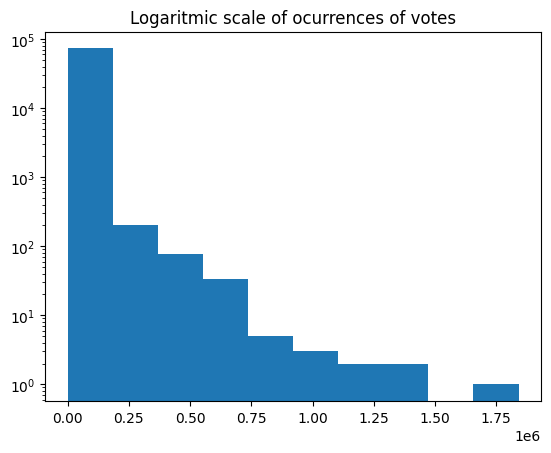

In [13]:
votes = pd.read_sql("""SELECT * FROM movie_ratings """,conn)['numvotes']
plt.hist(votes, log=True);
plt.title('Logaritmic scale of ocurrences of votes');
print(f"This Column has a mean of {round(votes.mean(),2)} a median of {votes.median()} and a \
standard deviation of {round(votes.std(),2)}, is not worth to keep, is far from normally distributed")

We had to do a logaritmic adjust to evaluate the distribution, because of the big ocurrence of outliers. We decided tro discard this.

### Average Rating

Evaluating the distribution.

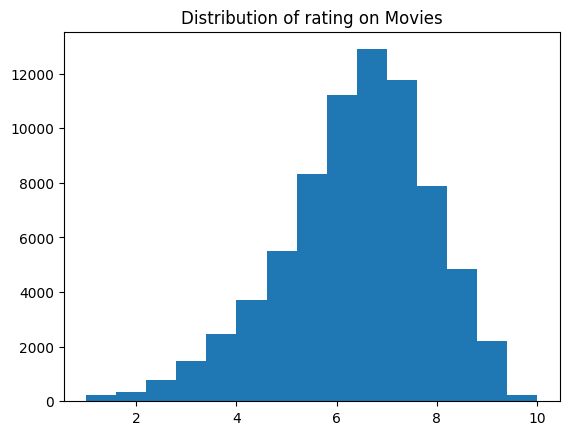

In [14]:
#Plotting the distribution of ratings
rating = pd.read_sql("""SELECT * FROM movie_ratings""",conn)['averagerating']
plt.hist(rating, bins=15);
plt.title('Distribution of rating on Movies');

We notice that the average rating has a distribution similar to a normal one, slightly skewed, we're going to keep it for further analysis.

### Creating the Query to extract the desired DataFrame

In [15]:
#Creating a Query for this database to Extract the Desired Data From it

imdb = pd.read_sql("""
SELECT primary_title, original_title, start_year, runtime_minutes, primary_name AS director_name, death_year, averagerating, genres
FROM movie_basics
LEFT JOIN directors USING(movie_id)
LEFT JOIN persons USING(person_id)
LEFT JOIN movie_ratings USING(movie_id)
GROUP BY movie_id
""",conn)

### Genres

As we notice above, the genres column has more than one value per movie, that'd make it hard to analyze going forward. We decided instead to created columns for the different genres and assign a binary value in case the movie falls into that specific genre.

In [16]:
#We make sure that every row has a value in the genre column.
imdb = imdb.drop_duplicates(subset=['primary_title'])
imdb['genres'].fillna('No Genre', inplace=True)
# Split the 'genres' column into a list of genres and then explode them into separate rows
imdb['genres'] = imdb['genres'].str.split(',')
imdb = imdb.explode('genres')
# Create binary indicators for each genre
for genre in imdb['genres'].dropna().unique():
    imdb[genre] = imdb['genres'].str.contains(genre).astype(int)
# Drop the original genres column
imdb.drop(columns=['genres'], inplace=True)

That made what we needed, but now we have as many rows per movie as genres they're in, we need to consolidate them

In [17]:
# Separate what are "genres column" from "non genres column"
non_genre_columns = ['primary_title', 'original_title','start_year','runtime_minutes','director_name','death_year','averagerating']
genre_columns = imdb.columns.difference(non_genre_columns)
# Group by 'primary_title' and sum the genre columns
genres_consolidated = imdb.groupby('primary_title', as_index=False)[genre_columns].sum()

#Merging all the columns together
imdb = pd.merge(imdb[non_genre_columns], genres_consolidated, on='primary_title')
#Elimintating duplicates based on primary_title
imdb = imdb.drop_duplicates(subset=['primary_title'])
imdb.reset_index(drop=True, inplace=True)

### Null values

Different methods were used to fill the null values in our database.

The most important to keep in mind is the averagerating, filled by the median of the values in the column.

In [18]:
#If we don't have the original_title, we'll just keep the primary_title.
imdb['original_title'].fillna(imdb['primary_title'], inplace=True)
#For runtime_minutes and death_year, we'll use 0 as a placeholder value
imdb['runtime_minutes'].fillna(0, inplace=True)
imdb['death_year'].fillna(0, inplace=True)
#For directors, we'll replace with 'Unknown'
imdb['director_name'].fillna('Unknown',inplace=True)
#For the averagerating we decided to fill the null values with the median.
imdb['averagerating'].fillna(imdb['averagerating'].median(),inplace=True)



### Exploring Resulting Data

In [19]:
imdb.head()

,primary_title,original_title,start_year,runtime_minutes,director_name,death_year,averagerating,Action,Adult,Adventure,...,No Genre,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,Sunghursh,Sunghursh,2013,175.0,Harnam Singh Rawail,2004.0,7.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,Mani Kaul,2011.0,7.2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Orson Welles,1985.0,6.9,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Sabse Bada Sukh,Sabse Bada Sukh,2018,0.0,Hrishikesh Mukherjee,2006.0,6.1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,Raoul Ruiz,2011.0,6.5,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136071 entries, 0 to 136070
Data columns (total 35 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   primary_title    136071 non-null  object 
 1   original_title   136071 non-null  object 
 2   start_year       136071 non-null  int64  
 3   runtime_minutes  136071 non-null  float64
 4   director_name    136071 non-null  object 
 5   death_year       136071 non-null  float64
 6   averagerating    136071 non-null  float64
 7   Action           136071 non-null  int32  
 8   Adult            136071 non-null  int32  
 9   Adventure        136071 non-null  int32  
 10  Animation        136071 non-null  int32  
 11  Biography        136071 non-null  int32  
 12  Comedy           136071 non-null  int32  
 13  Crime            136071 non-null  int32  
 14  Documentary      136071 non-null  int32  
 15  Drama            136071 non-null  int32  
 16  Family           136071 non-null  int3

In [21]:
imdb.describe()

,start_year,runtime_minutes,death_year,averagerating,Action,Adult,Adventure,Animation,Biography,Comedy,...,No Genre,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
count,136071.000000,136071.000000,136071.000000,136071.000000,136071.000000,136071.000000,136071.000000,136071.000000,136071.000000,136071.000000,...,136071.000000,136071.000000,136071.000000,136071.000000,136071.000000,136071.000000,136071.000000,136071.000000,136071.000000,136071.000000
mean,2014.561413,67.518325,12.702317,6.418684,0.070037,0.000184,0.044859,0.019754,0.061086,0.176481,...,0.035944,0.000698,0.063489,0.022613,0.000066,0.015382,0.000367,0.076754,0.009664,0.003160
std,2.732568,156.417561,159.460165,1.055786,0.255210,0.013553,0.206995,0.139156,0.239488,0.381231,...,0.186152,0.026414,0.243841,0.148667,0.008133,0.123066,0.019166,0.266202,0.097830,0.056126
min,2010.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2012.000000,37.000000,0.000000,6.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2015.000000,79.000000,0.000000,6.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2017.000000,95.000000,0.000000,6.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2027.000000,51420.000000,2019.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Runtime

We can advert that there are some outliers that won't allow us to visualize the complete data distribution.

We created a threshold to be able to visualize the data properly without the big outliers.

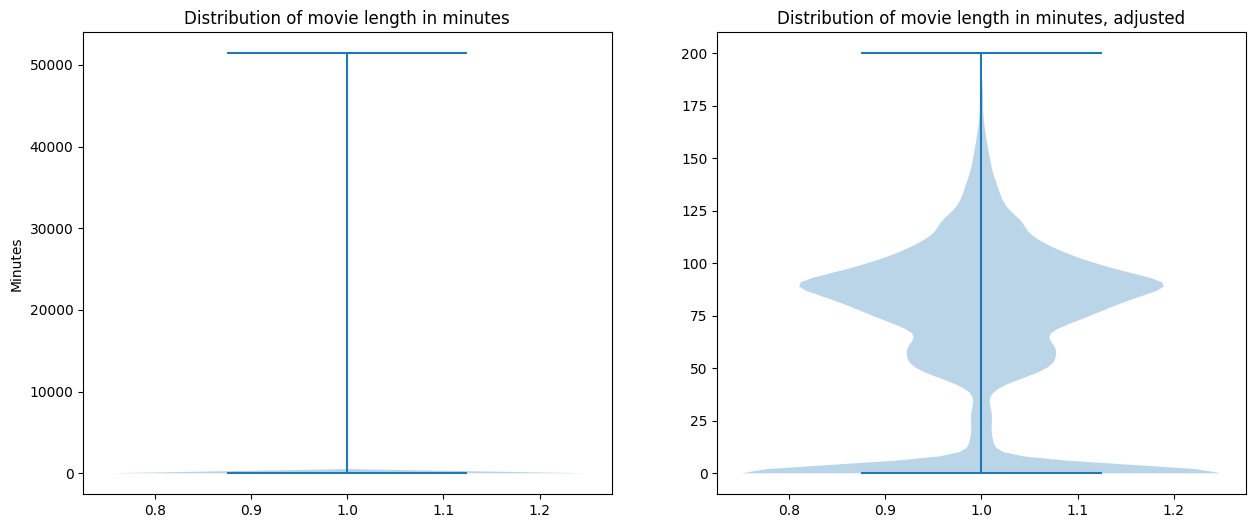

In [22]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(15,6))
ax1.violinplot(imdb['runtime_minutes'])
ax1.set_title('Distribution of movie length in minutes')
ax1.set_ylabel('Minutes');

threshold = 200  # Adjust this threshold based on your data
runtime_with_threshold = [x for x in imdb['runtime_minutes'] if x <= threshold]
ax2.violinplot(runtime_with_threshold)
ax2.set_title('Distribution of movie length in minutes, adjusted');

### What genres the movies are?

Now we continue to analyze the dataset by vieweing the number of genres ocurrences in the dataset.

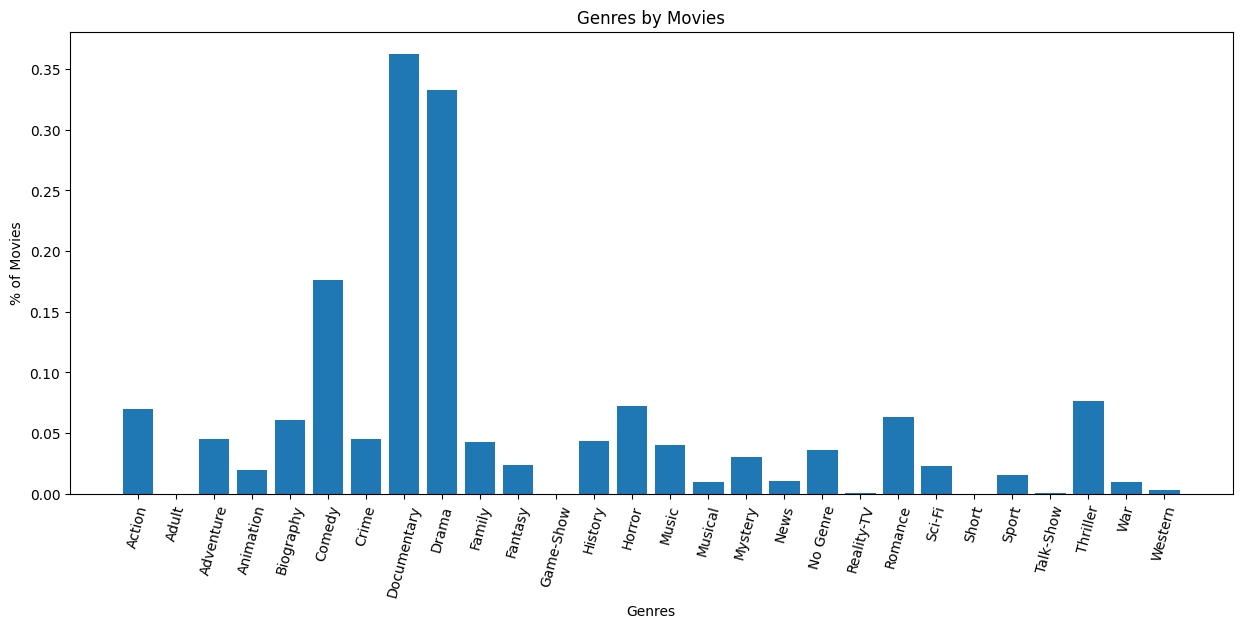

In [23]:
#Creating a category_columns list
category_columns = ['Action', 'Adult',
       'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Game-Show', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'News', 'No Genre', 'Reality-TV', 'Romance',
       'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']
# Adding the total ocurrence of genre in the dataset
columns_sums = imdb[category_columns].sum()
fig, ax = plt.subplots(figsize=(15,6))

#Plotting the sums divided by the length of the dataset to get the % of ocurrence in the movies
plt.bar(columns_sums.index, columns_sums/len(imdb))
plt.xticks(rotation=75)
plt.title('Genres by Movies')
plt.xlabel('Genres')
plt.ylabel('% of Movies');
        

As we can see there's a big % of movies that falls in either documentary or drama. We need to keep in mind that some movies might fall into more than once category.

## Movie_gross
Since we're going to work only with US based awards, we're going to focus on domestic gross rather than foreign_gross.

We drop all the columns and rows that we don't need or are irrelevant for our analysis.

In [24]:
#Dropping unnecessary columns and rows
movie_gross.drop(columns=['studio','year','foreign_gross'],inplace=True)
movie_gross.dropna(axis=0, inplace=True)

In [25]:
movie_gross.describe()

,domestic_gross
count,3.359000e+03
mean,2.874585e+07
std,6.698250e+07
min,1.000000e+02
25%,1.200000e+05
50%,1.400000e+06
75%,2.790000e+07
max,9.367000e+08


## TMDB movies

In [26]:
tmdb_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


In [27]:
tmdb_movies.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [28]:
#Keeping just the release year instead of the full date
tmdb_movies['release_year'] = tmdb_movies['release_date'].str[:4]
# drop unnecessary columns
tmdb_movies.drop(columns=['Unnamed: 0','original_language','popularity','vote_average','vote_count','release_date'],inplace=True)

### Genre unification
In this dataframe, the Genre column was identified just as ids. Founding online a dictionary with the corresponding Genre by map.
We're able to replace the numbers by the actual genre name.

After doing this, we found the same issue that on our IMBD database, having the genres combined instead of separated. Therefore, we create a new set of columns for the genres with binary values if the movie belongs to it

In [29]:
#Creating the genre dictionary
genre_mapping = {12: 'Adventure',
                 14: 'Fantasy',     
                 16: 'Animation',     
                 18: 'Drama',     
                 27: 'Horror',     
                 28: 'Action',     
                 35: 'Comedy',     
                 36: 'History',     
                 37: 'Western',     
                 53: 'Thriller',     
                 80: 'Crime',     
                 99: 'Documentary',     
                 9648: 'Mystery',     
                 10402: 'Music',     
                 10749: 'Romance',     
                 10751: 'Family',     
                 10752: 'War',     
                 10770: 'TV Movie',     
                 878: 'Science Fiction'} 

#Creating a function that will substitute the number with the corresponding genre.

def map_genre_ids(ids_str):
    ids = eval(ids_str)
    genres = [genre_mapping.get(id, 'Unknown') for id in ids]
    return ','.join(genres)
# Applying function to my data    
tmdb_movies['genres'] = tmdb_movies['genre_ids'].apply(map_genre_ids)
tmdb_movies.drop(columns='genre_ids',inplace=True)
#Everything that doesn't have a genre, substitute with 'Unknown'.
tmdb_movies.loc[tmdb_movies['genres'] == '', 'genres'] = 'Unknown'

In [30]:
#We make sure that every row has a value in the genre column.
tmdb_movies = tmdb_movies.drop_duplicates(subset=['id'])

# Split the 'genres' column into a list of genres and then explode them into separate rows
tmdb_movies['genres'] = tmdb_movies['genres'].str.split(',')

tmdb_movies = tmdb_movies.explode('genres')

# Create binary indicators for each genre
for genre in tmdb_movies['genres'].dropna().unique():
    tmdb_movies[genre] = tmdb_movies['genres'].str.contains(genre).astype(int)
# Drop the original genres column
tmdb_movies.drop(columns=['genres'], inplace=True)

# Separate what are "genres column" from "non genres column"
non_genre_columns = ['id','original_title','title','release_year']
genre_columns = tmdb_movies.columns.difference(non_genre_columns)
# Group by 'primary_title' and sum the genre columns
genres_consolidated = tmdb_movies.groupby('id', as_index=False)[genre_columns].sum()

#Merging all the columns together
tmdb_movies = pd.merge(tmdb_movies[non_genre_columns], genres_consolidated, on='id')
#Elimintating duplicates based on primary_title
tmdb_movies = tmdb_movies.drop_duplicates(subset=['id'])
tmdb_movies.reset_index(drop=True, inplace=True)

In [31]:
tmdb_movies['release_year'].value_counts().sort_index(ascending=False)

release_year
2020       1
2019      63
2018    2496
2017    2921
2016    2970
        ... 
1946       1
1939       1
1936       1
1933       1
1930       1
Name: count, Length: 66, dtype: int64

## Movie_budgets

In [32]:
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


### Adjusting type

As we can see in the information about the movie_budgets data, we have the production_budget, the domestic_Gross and the worldwide_gross as object instead of integers.

We remove some of the characters that will create an issue by transforming the datatype, and afterwards we'll create two new columns to be able to visualize the domestic gross to budget ratio.

In [33]:
# Converting columns from string to numeric data types
columns_to_convert = ['worldwide_gross', 'production_budget', 'domestic_gross']
for col in columns_to_convert:
    movie_budgets[col] = pd.to_numeric(movie_budgets[col].str.replace('[$,]', '', regex=True), errors='coerce')
#creating a new column for worldwide_gross/production_budget measuring the amount made vs the amount spent
movie_budgets['worldwide_gross/production_budget'] = movie_budgets['worldwide_gross']/movie_budgets['production_budget']
#doing the same but for domestic gross
movie_budgets['domestic_gross/production_budget'] = movie_budgets['domestic_gross']/movie_budgets['production_budget']
#checking that it worked
movie_budgets.head(1)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,worldwide_gross/production_budget,domestic_gross/production_budget
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,6.532577,1.78943


# Awards Databases

Since we're trying to figure out which movies provide the most awards, we got access to a Database of the golge globe Awards from 1944 to 2020.

We'll try to explore the data to determine which factors make a movie worth of awards

## Golden Globes

### Exploring the data

In [34]:
golden_globe_awards.head()

,year_film,year_award,ceremony,category,nominee,film,win
0,1943,1944,1,Best Performance by an Actress in a Supporting...,Katina Paxinou,For Whom The Bell Tolls,True
1,1943,1944,1,Best Performance by an Actor in a Supporting R...,Akim Tamiroff,For Whom The Bell Tolls,True
2,1943,1944,1,Best Director - Motion Picture,Henry King,The Song Of Bernadette,True
3,1943,1944,1,Picture,The Song Of Bernadette,NaN,True
4,1943,1944,1,Actress In A Leading Role,Jennifer Jones,The Song Of Bernadette,True


In [35]:
golden_globe_awards.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7991 entries, 0 to 7990
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   year_film   7991 non-null   int64 
 1   year_award  7991 non-null   int64 
 2   ceremony    7991 non-null   int64 
 3   category    7991 non-null   object
 4   nominee     7991 non-null   object
 5   film        6191 non-null   object
 6   win         7991 non-null   bool  
dtypes: bool(1), int64(3), object(3)
memory usage: 382.5+ KB


### Exploring and cleaning
We're going to use information about the winners, so we don't need to keep the people that was just nomineed.

In the exploration, we noticed that when the movie is the "nominee", the 'film' column gets a null value, so in those cases we'll copy the name from nominee into film.

We also remove unnecessary columns.

In [36]:
#Keeping only the winners, and dropping unnecessary columns
#When the nominee was the movie itself instead of an specific Crew member, the film cell was null.
# Having the Name of the film in the 'nominee' column. We replace accordingly
golden_globe_awards = golden_globe_awards.loc[golden_globe_awards['win'] == True]
golden_globe_awards.drop(columns=['year_award','ceremony','win'],inplace=True)
golden_globe_awards['film'] = golden_globe_awards['film'].fillna(golden_globe_awards['nominee'])

In [37]:
golden_globe_awards['category'].value_counts()

category
Best Performance by an Actress in a Supporting Role in any Motion Picture    79
Best Director - Motion Picture                                               77
Best Performance by an Actor in a Supporting Role in any Motion Picture      77
Best Performance by an Actress in a Motion Picture - Drama                   71
Best Performance by an Actor in a Motion Picture - Drama                     71
                                                                             ..
Actress In A Supporting Role - Television Series                              1
Actor In A Supporting Role - Television Series                                1
Actor In A Television Series - Musical Or Comedy                              1
Actor In A Television Series - Drama                                          1
Television Producer/Director                                                  1
Name: count, Length: 72, dtype: int64

### Categories
By evaluating the categories for the award, we decided to remove everything related to television shows (Since we're examining movies), and foreign awards, since our analysis is US based.

Also, we're consolidate the categories to make it easier to analyze.

In [38]:
#Removing awards not related to US movies
golden_globe_awards = golden_globe_awards[~golden_globe_awards['category'].str.contains('Television')]
golden_globe_awards = golden_globe_awards[~golden_globe_awards['category'].str.contains('Foreign')]

In [39]:
#Creating a category cleaning function
def cat_cleaner(char, cat):
    for i in char:
       golden_globe_awards.loc[golden_globe_awards['category'].str.contains(i,case=False), 'category'] = cat

#Creating a list that includes certain keywords that give us hints on the category type
soundtrack = ['song','music']
production = ['cinematography','screenplay','song','use of color']
best_actor = ['actor','performance']
directing = ['directing','director']
best_movie = ['picture']
best_actress = ['actress']

#Applying the category function

cat_cleaner(best_actor, 'Best Actor')
cat_cleaner(best_movie, 'Best Picture')
cat_cleaner(soundtrack, 'Soundtrack')
cat_cleaner(production, 'Production')
cat_cleaner(best_actress, 'Best Actress')
cat_cleaner(directing, 'Best Director')

#Every prize that won't fall in the categories mentioned above will be marked as 'others' 
golden_globe_awards.loc[((golden_globe_awards['category'] != 'Best Actor') & (golden_globe_awards['category'] != 'Best Picture') & 
                         (golden_globe_awards['category'] != 'Soundtrack') & (golden_globe_awards['category'] != 'Production') & 
                        (golden_globe_awards['category'] != 'Best Actress') & (golden_globe_awards['category'] != 'Best Director')),
                          'category'] = 'Others' 

Re-exploring the data

In [40]:
golden_globe_awards['category'].value_counts()

category
Best Actor      486
Best Picture    429
Others           97
Best Actress     67
Soundtrack       23
Production       14
Name: count, dtype: int64

In [41]:
golden_globe_awards.head()

,year_film,category,nominee,film
0,1943,Best Actor,Katina Paxinou,For Whom The Bell Tolls
1,1943,Best Actor,Akim Tamiroff,For Whom The Bell Tolls
2,1943,Best Picture,Henry King,The Song Of Bernadette
3,1943,Best Picture,The Song Of Bernadette,The Song Of Bernadette
4,1943,Best Actress,Jennifer Jones,The Song Of Bernadette


In [42]:
yearly = golden_globe_awards.groupby('year_film').count()

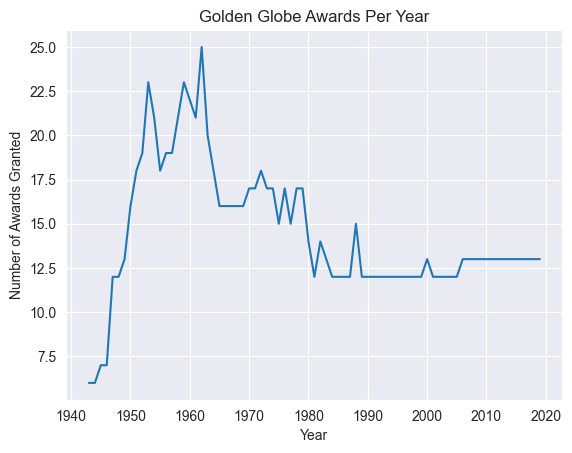

In [43]:
sns.set_style('darkgrid')
sns.lineplot(x = yearly.index, y = yearly['category'])
plt.title('Golden Globe Awards Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Awards Granted');

We can see based on the above visualization, that the amount of awards per year has decreasedin comparison with their peak in the sixties, having 'plateau' aroun 1990, where the amount of awards has stayed the same.

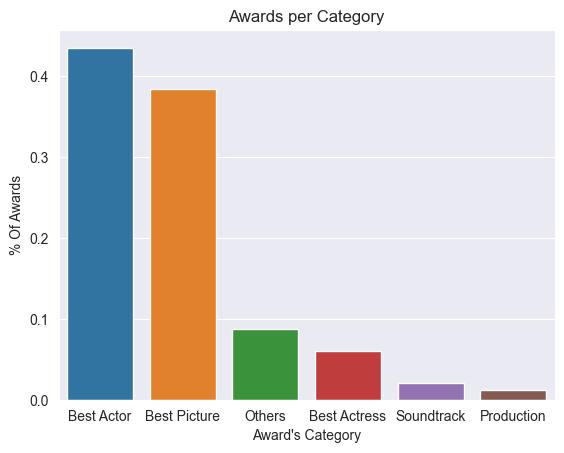

In [44]:
golden_globe_categories = golden_globe_awards['category'].value_counts(normalize=True)
sns.barplot(x = golden_globe_categories.index, y = golden_globe_categories)
plt.title('Awards per Category')
plt.xlabel("Award's Category")
plt.ylabel('% Of Awards');

In the above barplot, we can see how Best Actor and Best Picture are a big part of the complete set of awards given by the Golden globes over the years

### Creating Pivot tables Grouping nominees and films for the Golden Globes

For further analysis, we're creating tables grouped by films and nominees, allowing us to better explore the data.

In [45]:
#Creating a Table showing the golden globe awards grouped by film name.
golden_globe_by_film = golden_globe_awards.groupby('film').agg({'year_film': 'first', 'category': 'count'}).reset_index()
golden_globe_by_film.columns = ['Name', 'Year', 'Number Of Awards']
#Creating a Table showing the golden globe awards grouped by nominees.
golden_globe_by_nominee = golden_globe_awards.groupby('nominee').agg({'year_film': 'first', 'category': 'count'}).reset_index()
golden_globe_by_nominee.columns = ['Nominee', 'Year', 'Number Of Awards']

### Name matcher
With the new tables that we just created, we can merge them with the IMDb table, to get more insight into the movies that won awards.

Unfortunately, sometimes the names are not exactly the same in different tables, that's why we created a 'name_matcher' function, that allows us to create a similarity score between some names, and if that score is equal or above a threshold, cretaes a tuple with both names and the similarity score, to allow us later to merge them together based on it.


In [46]:
#Creating name_matcher function
def name_matcher(list1, list2, threshold):
    pairs = []
    for name1 in list1:
        for name2 in list2:
            similarity_score = fuzz.ratio(name1,name2)
            if similarity_score >= threshold:
                pairs.append((name1, name2, similarity_score))
    return pairs

Now that we have the function, we remove spaces and set everything lowercase to make it easiear to match

In [47]:
# Remove spaces from movie names and convert to lowercase for easier matching
golden_globe_by_film['Name_formatted'] = golden_globe_by_film['Name'].str.replace(' ', '').str.lower()
imdb['primary_title_cleaned'] = imdb['primary_title'].str.replace(' ', '').str.lower()

In [48]:
#Assigning the variable 'pairs' to the name_matcher function, using the names that we cleaned in both golden globes and imdb.
# Setting up a threshold of 90
pairs = name_matcher(golden_globe_by_film['Name_formatted'],imdb['primary_title_cleaned'],90)

# Create a DataFrame from the list of matching pairs
pairs_GG_by_film = pd.DataFrame(pairs, columns=[ 'Golden_Globe_name','imdb_name', 'similarity_score'])

# Merge the two datasets using the paired Dataframe as a reference for the keys.
pairs_GG_by_film = pd.merge(imdb, pairs_GG_by_film, left_on='primary_title_cleaned', right_on='imdb_name', how='inner')
merged_data_GG_by_film = pd.merge(pairs_GG_by_film, golden_globe_by_film, left_on='Golden_Globe_name', right_on='Name_formatted', how='inner')
merged_data_GG_by_film.head()

,primary_title,original_title,start_year,runtime_minutes,director_name,death_year,averagerating,Action,Adult,Adventure,...,War,Western,primary_title_cleaned,Golden_Globe_name,imdb_name,similarity_score,Name,Year,Number Of Awards,Name_formatted
0,Toy Story 3,Toy Story 3,2010,103.0,Lee Unkrich,0.0,8.3,0,0,1,...,0,0,toystory3,toystory3,toystory3,100,Toy Story 3,2010,1,toystory3
1,Lincoln,Lincoln,2012,150.0,Steven Spielberg,0.0,7.4,0,0,0,...,0,0,lincoln,lincoln,lincoln,100,Lincoln,2012,1,lincoln
2,Life of Pi,Life of Pi,2012,127.0,Ang Lee,0.0,7.9,0,0,1,...,0,0,lifeofpi,lifeofpi,lifeofpi,100,Life of Pi,2012,1,lifeofpi
3,Dallas Buyers Club,Dallas Buyers Club,2013,117.0,Jean-Marc Vallée,0.0,8.0,0,0,0,...,0,0,dallasbuyersclub,dallasbuyersclub,dallasbuyersclub,100,Dallas Buyers Club,2013,2,dallasbuyersclub
4,Conan the Barbarian,Conan the Barbarian,2011,113.0,Marcus Nispel,0.0,5.2,1,0,1,...,0,0,conanthebarbarian,conanthebarbarian,conanthebarbarian,100,Conan the Barbarian,1982,1,conanthebarbarian


During the merge, is possible that we see two movies that has the same, or very similar name, but being two actual different movies, in this case we're using the year as a reference. But since there's a chance that a movie get an award the year after it was released, we creates another column with the magnitude of difference between the year of the awards and the year it was released.

Everything above two years is discarded.

In [49]:
#creating a new column called year_difference, which will be used for cleaning mismatches that had high similarity scores
merged_data_GG_by_film['year_difference'] = abs(merged_data_GG_by_film['start_year'] - merged_data_GG_by_film['Year'])
merged_data_GG_by_film = merged_data_GG_by_film[merged_data_GG_by_film['year_difference'] < 2]

merged_data_GG_by_film.head()

,primary_title,original_title,start_year,runtime_minutes,director_name,death_year,averagerating,Action,Adult,Adventure,...,Western,primary_title_cleaned,Golden_Globe_name,imdb_name,similarity_score,Name,Year,Number Of Awards,Name_formatted,year_difference
0,Toy Story 3,Toy Story 3,2010,103.0,Lee Unkrich,0.0,8.3,0,0,1,...,0,toystory3,toystory3,toystory3,100,Toy Story 3,2010,1,toystory3,0
1,Lincoln,Lincoln,2012,150.0,Steven Spielberg,0.0,7.4,0,0,0,...,0,lincoln,lincoln,lincoln,100,Lincoln,2012,1,lincoln,0
2,Life of Pi,Life of Pi,2012,127.0,Ang Lee,0.0,7.9,0,0,1,...,0,lifeofpi,lifeofpi,lifeofpi,100,Life of Pi,2012,1,lifeofpi,0
3,Dallas Buyers Club,Dallas Buyers Club,2013,117.0,Jean-Marc Vallée,0.0,8.0,0,0,0,...,0,dallasbuyersclub,dallasbuyersclub,dallasbuyersclub,100,Dallas Buyers Club,2013,2,dallasbuyersclub,0
6,How to Train Your Dragon 2,How to Train Your Dragon 2,2014,102.0,Dean DeBlois,0.0,7.8,1,0,1,...,0,howtotrainyourdragon2,howtotrainyourdragon2,howtotrainyourdragon2,100,How to Train Your Dragon 2,2014,1,howtotrainyourdragon2,0


We prepared to do the same with the data of the golden globes by nominees. This is because we might find ocurrences in which the name of the movie was actually in the nominee column.

To make sure that we're keeping all of them, we're merging the imdb database with both grouped tables (by film and by nominee), afterwards we'll concatenate them by rows, and eliminate duplicates, so we can have only one ocurrence per movie.

In [50]:

# Remove characters and convert to lowercase using chaining methods
golden_globe_by_nominee['Nominee_formatted'] = (
    golden_globe_by_nominee['Nominee']
    .str.replace(',', '')
    .str.replace(' ', '')
    .str.replace('"', '')
    .str.lower()
)

# Remove characters and convert to lowercase using chaining methods
imdb['primary_title_cleaned'] = (
    imdb['primary_title']
    .str.replace(',', '')
    .str.replace(' ', '')
    .str.replace('"', '')
    .str.lower()
)

In [51]:
#Applying the name_matcher function to the new datasets we want to merge.
pairs2 = name_matcher(golden_globe_by_nominee['Nominee_formatted'], imdb['primary_title_cleaned'], 90)

# Create a DataFrame from the list of matching pairs
pairs_GG_by_nominee = pd.DataFrame(pairs2, columns=[ 'Golden_Globe_nominee','imdb_name', 'similarity_score'])


# Merge the two datasets using the paired Dataframe as a reference for the keys.
pairs_GG_by_nominee = pd.merge(imdb, pairs_GG_by_nominee, left_on='primary_title_cleaned', right_on='imdb_name', how='inner')
merged_data_GG_by_nominee = pd.merge(pairs_GG_by_nominee, golden_globe_by_nominee, left_on='Golden_Globe_nominee', right_on='Nominee_formatted', how='inner')

#creating a new column called year_difference, which will be used for cleaning mismatches that had high similarity scores
merged_data_GG_by_nominee['year_difference'] = abs(merged_data_GG_by_nominee['start_year'] - merged_data_GG_by_nominee['Year'])
merged_data_GG_by_nominee = merged_data_GG_by_nominee[merged_data_GG_by_nominee['year_difference'] < 2]

merged_data_GG_by_nominee.head()

,primary_title,original_title,start_year,runtime_minutes,director_name,death_year,averagerating,Action,Adult,Adventure,...,Western,primary_title_cleaned,Golden_Globe_nominee,imdb_name,similarity_score,Nominee,Year,Number Of Awards,Nominee_formatted,year_difference
0,Toy Story 3,Toy Story 3,2010,103.0,Lee Unkrich,0.0,8.3,0,0,1,...,0,toystory3,toystory3,toystory3,100,Toy Story 3,2010,1,toystory3,0
2,How to Train Your Dragon 2,How to Train Your Dragon 2,2014,102.0,Dean DeBlois,0.0,7.8,1,0,1,...,0,howtotrainyourdragon2,howtotrainyourdragon2,howtotrainyourdragon2,100,How to Train Your Dragon 2,2014,1,howtotrainyourdragon2,0
11,Argo,Argo,2012,120.0,Ben Affleck,0.0,7.7,0,0,0,...,0,argo,argo,argo,100,Argo,2012,1,argo,0
13,Coco,Coco,2018,0.0,Unknown,0.0,6.5,0,0,0,...,0,coco,coco,coco,100,Coco,2017,1,coco,1
14,Boyhood,Boyhood,2014,165.0,Richard Linklater,0.0,7.9,0,0,0,...,0,boyhood,boyhood,boyhood,100,Boyhood,2014,1,boyhood,0


In [52]:
# Concatenate the dfs
Golden_Globes_Winners = pd.concat([merged_data_GG_by_film, merged_data_GG_by_nominee], axis=0)
#reset the index
Golden_Globes_Winners.reset_index(drop=True, inplace=True)

Golden_Globes_Winners.head()

,primary_title,original_title,start_year,runtime_minutes,director_name,death_year,averagerating,Action,Adult,Adventure,...,imdb_name,similarity_score,Name,Year,Number Of Awards,Name_formatted,year_difference,Golden_Globe_nominee,Nominee,Nominee_formatted
0,Toy Story 3,Toy Story 3,2010,103.0,Lee Unkrich,0.0,8.3,0,0,1,...,toystory3,100,Toy Story 3,2010,1,toystory3,0,NaN,NaN,NaN
1,Lincoln,Lincoln,2012,150.0,Steven Spielberg,0.0,7.4,0,0,0,...,lincoln,100,Lincoln,2012,1,lincoln,0,NaN,NaN,NaN
2,Life of Pi,Life of Pi,2012,127.0,Ang Lee,0.0,7.9,0,0,1,...,lifeofpi,100,Life of Pi,2012,1,lifeofpi,0,NaN,NaN,NaN
3,Dallas Buyers Club,Dallas Buyers Club,2013,117.0,Jean-Marc Vallée,0.0,8.0,0,0,0,...,dallasbuyersclub,100,Dallas Buyers Club,2013,2,dallasbuyersclub,0,NaN,NaN,NaN
4,How to Train Your Dragon 2,How to Train Your Dragon 2,2014,102.0,Dean DeBlois,0.0,7.8,1,0,1,...,howtotrainyourdragon2,100,How to Train Your Dragon 2,2014,1,howtotrainyourdragon2,0,NaN,NaN,NaN


In [53]:
Golden_Globes_Winners.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 47 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   primary_title          85 non-null     object 
 1   original_title         85 non-null     object 
 2   start_year             85 non-null     int64  
 3   runtime_minutes        85 non-null     float64
 4   director_name          85 non-null     object 
 5   death_year             85 non-null     float64
 6   averagerating          85 non-null     float64
 7   Action                 85 non-null     int32  
 8   Adult                  85 non-null     int32  
 9   Adventure              85 non-null     int32  
 10  Animation              85 non-null     int32  
 11  Biography              85 non-null     int32  
 12  Comedy                 85 non-null     int32  
 13  Crime                  85 non-null     int32  
 14  Documentary            85 non-null     int32  
 15  Drama   

In [54]:
#Eliminating unnecessary columns
Golden_Globes_Winners.drop(
    ['start_year',
     'primary_title_cleaned',
     'year_difference',
     'Nominee_formatted',
     'Name_formatted',
     'Name',
     'death_year',
     'original_title',
     'Golden_Globe_nominee',
     'imdb_name',
     'similarity_score',
     'Nominee',
     'Golden_Globe_name'
     ], axis=1, inplace=True)

Golden_Globes_Winners.drop_duplicates(inplace=True)
Golden_Globes_Winners.head()

,primary_title,runtime_minutes,director_name,averagerating,Action,Adult,Adventure,Animation,Biography,Comedy,...,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western,Year,Number Of Awards
0,Toy Story 3,103.0,Lee Unkrich,8.3,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,2010,1
1,Lincoln,150.0,Steven Spielberg,7.4,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,2012,1
2,Life of Pi,127.0,Ang Lee,7.9,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,2012,1
3,Dallas Buyers Club,117.0,Jean-Marc Vallée,8.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,2013,2
4,How to Train Your Dragon 2,102.0,Dean DeBlois,7.8,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,2014,1


## Academy Awards

### Exploring the data

In [55]:
academy_awards.head()

,Year,Ceremony,Award,Winner,Name,Film
0,1927/1928,1,Actor,NaN,Richard Barthelmess,The Noose
1,1927/1928,1,Actor,1.0,Emil Jannings,The Last Command
2,1927/1928,1,Actress,NaN,Louise Dresser,A Ship Comes In
3,1927/1928,1,Actress,1.0,Janet Gaynor,7th Heaven
4,1927/1928,1,Actress,NaN,Gloria Swanson,Sadie Thompson


In [56]:
academy_awards.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9964 entries, 0 to 9963
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      9964 non-null   object 
 1   Ceremony  9964 non-null   int64  
 2   Award     9964 non-null   object 
 3   Winner    2321 non-null   float64
 4   Name      9964 non-null   object 
 5   Film      9631 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 467.2+ KB


In [57]:
academy_awards.describe(include='all')

,Year,Ceremony,Award,Winner,Name,Film
count,9964,9964.000000,9964,2321.0,9964,9631
unique,88,NaN,114,NaN,5747,6363
top,1942,NaN,Directing,NaN,Meryl Streep,Metro-Goldwyn-Mayer
freq,186,NaN,429,NaN,19,60
mean,NaN,45.471798,NaN,1.0,NaN,NaN
std,NaN,24.841392,NaN,0.0,NaN,NaN
min,NaN,1.000000,NaN,1.0,NaN,NaN
25%,NaN,23.000000,NaN,1.0,NaN,NaN
50%,NaN,44.000000,NaN,1.0,NaN,NaN
75%,NaN,68.000000,NaN,1.0,NaN,NaN


### Conditional switching

Some categories, as in the Golden Globes dataset, have the nominee and the film values swapped, we checked the entire database and we found that there are some specific awards and years that have the above-mentioned values swapped.

In [58]:
#Creation conditions to swap the film and the name.
condition = ((academy_awards['Year'] == '1929/1930') & ((academy_awards['Award'] == 'Art Direction')\
         | (academy_awards['Award'] == 'Outstanding Production')\
         | (academy_awards['Award'] == 'Sound Recording') | (academy_awards['Award'] == 'Writing')))
#Swapping name and Film
temp = academy_awards.loc[condition, 'Film'].copy()
academy_awards.loc[condition, 'Film'] = academy_awards.loc[condition, 'Name']
academy_awards.loc[condition, 'Name'] = temp

#Creating a list of new awards to switch
awards_switched = [
    'Writing (Adaptation)','Writing (Screenplay, Adapted)','Writing (Screenplay Adapted from Other Material)',
    'Writing (Screenplay Based on Material Previously Produced or Published)',
    'Writing (Screenplay Based on Material from Another Medium)',
    'Writing (Screenplay, Based on Material from Another Medium)', 'Animated Feature Film',
    'Writing (Original Screenplay)','Cinematography','Directing','Sound Mixing','Writing (Adapted Screenplay)','Documentary (Feature)',
    'Sound Editing','Costume Design','Visual Effects','Documentary (Short Subject)','Film Editing','Foreign Language Film',
    'Makeup and Hairstyling','Music (Original Score)','Best Picture','Production Design','Short Film (Animated)',
    'Short Film (Live Action)','Writing (Screenplay)'
]
#Switching them
condition2 = (academy_awards['Award'].isin(awards_switched)) & (academy_awards['Year'] != '1927/1928')
temp = academy_awards.loc[condition2, 'Film'].copy()
academy_awards.loc[condition2, 'Film'] = academy_awards.loc[condition2, 'Name']
academy_awards.loc[condition2, 'Name'] = temp

In [59]:
academy_awards.head()

,Year,Ceremony,Award,Winner,Name,Film
0,1927/1928,1,Actor,NaN,Richard Barthelmess,The Noose
1,1927/1928,1,Actor,1.0,Emil Jannings,The Last Command
2,1927/1928,1,Actress,NaN,Louise Dresser,A Ship Comes In
3,1927/1928,1,Actress,1.0,Janet Gaynor,7th Heaven
4,1927/1928,1,Actress,NaN,Gloria Swanson,Sadie Thompson


### Unifying award categories

Over the year, the name of the awards has changed in different ways, we consolidate them in order to be able to determine the % of awards given per category

In [60]:
#Keeping just the winners. Dropping unnecessary columns and unifying the year column
academy_awards.dropna(subset = 'Winner', axis=0, inplace = True)
academy_awards.drop(columns=['Winner','Ceremony'],inplace=True)
academy_awards['Year'] = academy_awards['Year'].str.slice(0,4).astype(int)

In [61]:
#Dropping awards that won't be analyzed
academy_awards = academy_awards[~academy_awards['Award'].str.contains('Commendation')]
academy_awards = academy_awards[~academy_awards['Award'].str.contains('Honorary')]
academy_awards = academy_awards[~academy_awards['Award'].str.contains('Foreign')]
academy_awards = academy_awards[~academy_awards['Award'].str.contains('Humanitarian')]
#Creating a category cleaning function and a list that includes certain keywords that give us hints on the category type
def cat_cleaner(char, cat):
    for i in char:
       academy_awards.loc[academy_awards['Award'].str.contains(i,case=False), 'Award'] = cat

best_actress = ['actress']
best_actor = ['actor']
directing = ['directing','director']
music = ['music','sound']
writing  = ['writing']
production = ['dance','art','cinematography','special ach','effects','costume','makeup','production','editing']
overall_movie = ['documentary','short','picture','special award','feature film','Irving G. Thalberg Memorial Award','Gordon E. Sawyer Award']

#Applying the category cleaner function

cat_cleaner(overall_movie, 'Best Movie')
cat_cleaner(production, 'Production')
cat_cleaner(music, 'Soundtrack')
cat_cleaner(writing, 'Writing')
cat_cleaner(best_actor, 'Best Actor')
cat_cleaner(best_actress, 'Best Actress')
cat_cleaner(directing, 'Best Director')

How many awards have been granted per year?

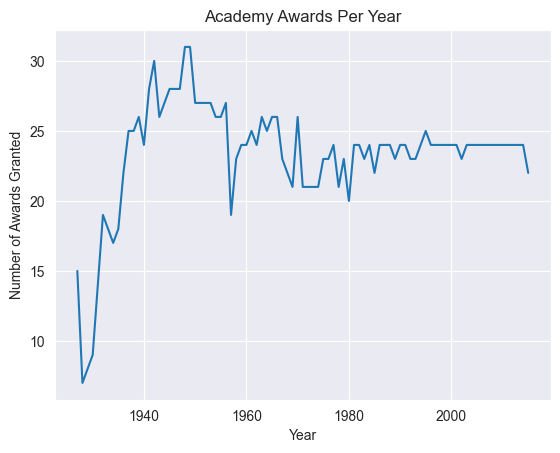

In [62]:
yearly_aa = academy_awards.groupby('Year').count()

sns.set_style('darkgrid')
sns.lineplot(x = yearly_aa.index, y = yearly_aa['Award'])
plt.title('Academy Awards Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Awards Granted');

As we can see, even though there was a peak around the 1950s, the amount of awards granted have been always between 20 and 25 for the last 50 years

#### How is the distribution of prizes per categories?

We saw on the golden globes dataset that the actor played an important role in the amount of awards a movie gets, how's the distribution in the Academy Awards?

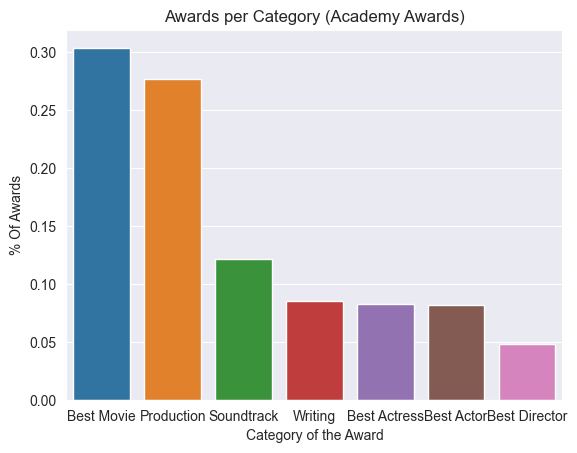

In [63]:
academy_categories = academy_awards['Award'].value_counts(normalize=True)
sns.barplot(x = academy_categories.index, y = academy_categories)
plt.title('Awards per Category (Academy Awards)')
plt.xlabel('Category of the Award')
plt.ylabel('% Of Awards');

Unlike the Golden Globes, the Academy Awards seems to grant a bigger part of their awards to categories related to the movies, being the actors aorund 16% of the total of awards granted.

### Creating Pivot tables Grouping nominees and films for the Academy Awards

As we did for the Golden Globes dataset, to make our analysis easier, we're going to group the Data by film and by nominees. We'll do the merging by both just to make sure that no film ends in the nominee column. 

In [64]:
#Creating the tables of the Academy Awards grouped by Film and Nominees.

academy_by_film = academy_awards.groupby('Film').agg({'Year': 'first', 'Award': 'count'}).reset_index()
academy_by_film.columns = ['Film', 'Year', 'Number Of Awards']

academy_by_nominee = academy_awards.groupby('Name').agg({'Year': 'first', 'Award': 'count'}).reset_index()
academy_by_nominee.columns = ['Name', 'Year', 'Number Of Awards']


#### Pairing the IMDb database and the Academy Awards grouped by Film name

In [65]:
# Remove spaces from movie names and convert to lowercase for easier matching

# Remove characters and convert to lowercase using chaining methods
academy_by_film['Film_formatted'] = (
    academy_by_film['Film']
    .str.replace(',', '')
    .str.replace(' ', '')
    .str.replace('"', '')
    .str.replace("'", '')
    .str.lower()
)

imdb['primary_title_cleaned'] = (
    imdb['primary_title']
    .str.replace(',', '')
    .str.replace(' ', '')
    .str.replace('"', '')
    .str.replace("'", '')
    .str.lower()
)


In [66]:
#Applying the name_matcher function
pairs3 = name_matcher(academy_by_film['Film_formatted'],imdb['primary_title_cleaned'],90)

# Create a DataFrame from the list of matching pairs
pairs_AA_by_film = pd.DataFrame(pairs3, columns=[ 'Academy_Film','imdb_name', 'similarity_score'])

# Merge the two datasets based on the similarity score threshold
pairs_AA_by_film = pd.merge(imdb, pairs_AA_by_film, left_on='primary_title_cleaned', right_on='imdb_name', how='inner')
merged_data_AA_by_film = pd.merge(pairs_AA_by_film, academy_by_film, left_on='Academy_Film', right_on='Film_formatted', how='inner')

#creating a new column called year_difference, which will be used for cleaning mismatches that had high similarity scores
merged_data_AA_by_film['year_difference'] = abs(merged_data_AA_by_film['start_year'] - merged_data_AA_by_film['Year'])
merged_data_AA_by_film = merged_data_AA_by_film[merged_data_AA_by_film['year_difference'] < 2]

merged_data_AA_by_film.head()

,primary_title,original_title,start_year,runtime_minutes,director_name,death_year,averagerating,Action,Adult,Adventure,...,Western,primary_title_cleaned,Academy_Film,imdb_name,similarity_score,Film,Year,Number Of Awards,Film_formatted,year_difference
2,Toy Story 3,Toy Story 3,2010,103.0,Lee Unkrich,0.0,8.3,0,0,1,...,0,toystory3,toystory3,toystory3,100,Toy Story 3,2010,1,toystory3,0
3,Lincoln,Lincoln,2012,150.0,Steven Spielberg,0.0,7.4,0,0,0,...,0,lincoln,lincoln,lincoln,100,Lincoln,2012,1,lincoln,0
4,Lincoln,Lincoln,2012,150.0,Steven Spielberg,0.0,7.4,0,0,0,...,0,lincoln,lincoln,lincoln,100,Lincoln,2012,1,lincoln,0
5,Lincoln,Lincoln,2012,150.0,Steven Spielberg,0.0,7.4,0,0,0,...,0,lincoln,lincoln,lincoln,100,Lincoln,2012,1,lincoln,0
6,Lincoln,Lincoln,2012,150.0,Steven Spielberg,0.0,7.4,0,0,0,...,0,lincoln,lincoln,lincoln,100,Lincoln,2012,1,lincoln,0


#### Pairing the IMDb database and the Academy Awards grouped by Nominees

In [67]:

# Remove characters and convert to lowercase using chaining methods
academy_by_nominee['Name_formatted'] = (
    academy_by_nominee['Name']
    .str.replace(',', '')
    .str.replace(' ', '')
    .str.replace('"', '')
    .str.replace('(', '')
    .str.replace(')', '')
    .str.lower()
)

imdb['primary_title_cleaned'] = (
    imdb['primary_title']
    .str.replace(',', '')
    .str.replace(' ', '')
    .str.replace('"', '')
    .str.replace('(', '')
    .str.replace(')', '')
    .str.lower()
)

In [68]:
#Applying the name_matcher function
pairs4 = name_matcher(academy_by_nominee['Name_formatted'],imdb['primary_title_cleaned'],90)

# Create a DataFrame from the list of matching pairs
pairs_AA_by_nominee = pd.DataFrame(pairs4, columns=[ 'Academy_nominee','imdb_name', 'similarity_score'])

# Merge the two datasets based on the similarity score threshold
pairs_AA_by_nominee = pd.merge(imdb, pairs_AA_by_nominee, left_on='primary_title_cleaned', right_on='imdb_name', how='inner')
merged_data_AA_by_nominee = pd.merge(pairs_AA_by_nominee, academy_by_nominee, left_on='Academy_nominee', right_on='Name_formatted', how='inner')

#creating a new column called year_difference, which will be used for cleaning mismatches that had high similarity scores
merged_data_AA_by_nominee['year_difference'] = abs(merged_data_AA_by_nominee['start_year'] - merged_data_AA_by_nominee['Year'])
merged_data_AA_by_nominee = merged_data_AA_by_nominee[merged_data_AA_by_nominee['year_difference'] < 2]

merged_data_AA_by_nominee.head()

,primary_title,original_title,start_year,runtime_minutes,director_name,death_year,averagerating,Action,Adult,Adventure,...,Western,primary_title_cleaned,Academy_nominee,imdb_name,similarity_score,Name,Year,Number Of Awards,Name_formatted,year_difference
1,The Wolfman,The Wolfman,2010,103.0,Joe Johnston,0.0,5.8,0,0,0,...,0,thewolfman,thewolfman,thewolfman,100,The Wolfman,2010,1,thewolfman,0
2,Hugo,Hugo,2011,126.0,Martin Scorsese,0.0,7.5,0,0,1,...,0,hugo,hugo,hugo,100,Hugo,2011,1,hugo,0
3,The Iron Lady,The Iron Lady,2011,105.0,Phyllida Lloyd,0.0,6.4,0,0,0,...,0,theironlady,theironlady,theironlady,100,The Iron Lady,2011,1,theironlady,0
8,Alice in Wonderland,Alice in Wonderland,2010,108.0,Tim Burton,0.0,6.5,0,0,1,...,0,aliceinwonderland,aliceinwonderland,aliceinwonderland,100,Alice in Wonderland,2010,1,aliceinwonderland,0


In [69]:
# Concatenate the dfs
Academy_Awards_Winners = pd.concat([merged_data_AA_by_film, merged_data_AA_by_nominee], axis=0)
Academy_Awards_Winners.reset_index(drop=True, inplace=True)
#Dropping Unnecessary columns
Academy_Awards_Winners.drop(
    ['start_year','primary_title_cleaned','year_difference',
     'Name_formatted','Name','death_year','original_title',
     'Academy_nominee','imdb_name','similarity_score',
     'Academy_Film','Film','Film_formatted',
     ], axis=1, inplace=True)
#Dropping Duplicates
Academy_Awards_Winners.drop_duplicates(inplace=True)
Academy_Awards_Winners.head()

,primary_title,runtime_minutes,director_name,averagerating,Action,Adult,Adventure,Animation,Biography,Comedy,...,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western,Year,Number Of Awards
0,Toy Story 3,103.0,Lee Unkrich,8.3,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,2010,1
1,Lincoln,150.0,Steven Spielberg,7.4,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,2012,1
5,Life of Pi,127.0,Ang Lee,7.9,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,2012,4
6,Ex Machina,108.0,Alex Garland,7.7,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,2015,1
7,Dallas Buyers Club,117.0,Jean-Marc Vallée,8.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,2013,2


We're going to visualize the distribution of the rating of award-winning movies, we'll set a vertical line on the mean of the whole IMDb dataset so we can evaluate how award-winning movies perform against all of them as far as ratings.

## Merging Awards Databases with Movie Budgets

In [70]:
pairs5 = name_matcher(academy_by_film['Film'],movie_budgets['movie'],92)

# Create a DataFrame from the list of matching pairs
matching_data = pd.DataFrame(pairs5, columns=['aa_name', 'mb_name', 'similarity_score'])
# Merge the two datasets based on the similarity score threshold
academy_movie_budgets = pd.merge(academy_by_film, matching_data, left_on='Film', right_on='aa_name', how='inner')
academy_movie_budgets = pd.merge(academy_movie_budgets, movie_budgets, left_on='mb_name', right_on='movie', how='inner')

academy_movie_budgets.drop(columns=['mb_name','aa_name','similarity_score','id','release_date','movie','Film_formatted'], inplace=True)
academy_movie_budgets.drop_duplicates(keep='first',inplace=True)
academy_movie_budgets.head()

,Film,Year,Number Of Awards,production_budget,domestic_gross,worldwide_gross,worldwide_gross/production_budget,domestic_gross/production_budget
0,12 Years a Slave,2013,1,20000000,56671993,181025343,9.051267,2.833600
1,12 Years a Slave,2013,2,20000000,56671993,181025343,9.051267,2.833600
2,20 Feet from Stardom,2013,1,1000000,4946250,5892466,5.892466,4.946250
3,A Beautiful Mind,2001,1,78000000,170708996,317668058,4.072667,2.188577
4,A Beautiful Mind,2001,3,78000000,170708996,317668058,4.072667,2.188577


In [71]:
pairs6 = name_matcher(golden_globe_by_film['Name'],movie_budgets['movie'],92)

# Create a DataFrame from the list of matching pairs
matching_data = pd.DataFrame(pairs6, columns=['gg_name', 'mb_name', 'similarity_score'])
# Merge the two datasets based on the similarity score threshold
golden_globes_movie_budgets = pd.merge(golden_globe_by_film, matching_data, left_on='Name', right_on='gg_name', how='inner')
golden_globes_movie_budgets = pd.merge(golden_globes_movie_budgets, movie_budgets, left_on='mb_name', right_on='movie', how='inner')

golden_globes_movie_budgets.drop(columns=['mb_name','gg_name','similarity_score','id','release_date','movie','Name_formatted'], inplace=True)
golden_globes_movie_budgets.drop_duplicates(keep='first',inplace=True)
golden_globes_movie_budgets.head()

,Name,Year,Number Of Awards,production_budget,domestic_gross,worldwide_gross,worldwide_gross/production_budget,domestic_gross/production_budget
0,12 Years a Slave,2013,1,20000000,56671993,181025343,9.051267,2.833600
1,A Beautiful Mind,2001,4,78000000,170708996,317668058,4.072667,2.188577
2,About Schmidt,2002,2,30000000,65005217,107054484,3.568483,2.166841
3,Adaptation,2002,2,18500000,22498520,32531759,1.758473,1.216136
4,Aladdin,1992,2,182000000,246734314,619234314,3.402386,1.355683


# Results

There are a massive number of factors to consider when investigating contribution to the production of an Award Winning movie. We analyzed historical data from the Academy Awards and Golden Globes in search of those characteristics.

## Comparing Award Winners with Regular Movies

We'd run a series of plots to visualize the actual difference between award winning movies and the rest of our dataset. One of the first things to evaluate is the ratings, does award winning movies have better average than the rest?

For this, we created a histogram on the ratings of both Academy Awards and Golden Globes and set up a vertical line where the mean of the IMDb database is on the average rating.

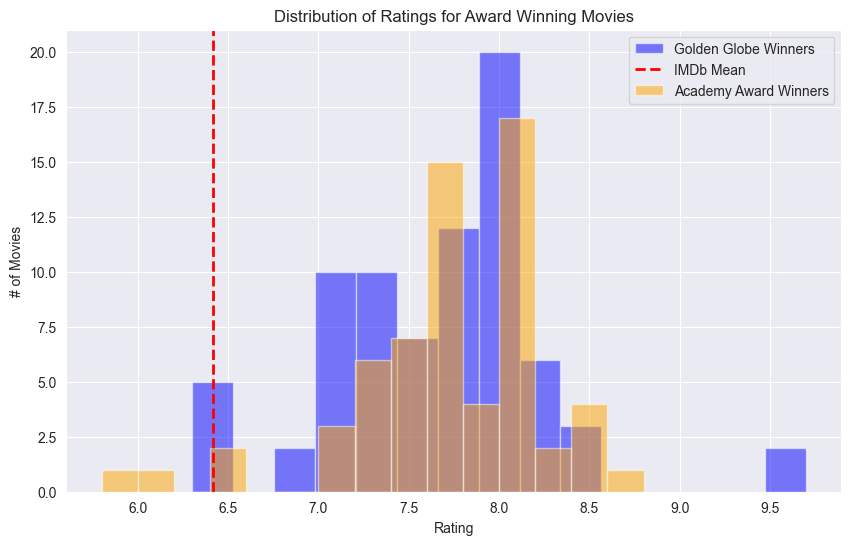

In [72]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot histogram for Golden Globe Winning Movies
rating_gg = Golden_Globes_Winners['averagerating']
ax.hist(rating_gg, bins=15, alpha=0.5, color='blue', label='Golden Globe Winners')

#Setting a vertical line for the mean of the IMDb movies dataset
ax.axvline(imdb['averagerating'].mean(), color='red', linestyle='dashed', linewidth=2, label='IMDb Mean')

# Plot histogram for Academy Award Winning Movies
rating_aa = Academy_Awards_Winners['averagerating']
ax.hist(rating_aa, bins=15, alpha=0.5, color='orange', label='Academy Award Winners')

# Set titles, labels, and legend
ax.set_title('Distribution of Ratings for Award Winning Movies')
ax.set_xlabel('Rating')
ax.set_ylabel('# of Movies')
ax.legend();

Above we can observe that movies that won awards usually perform better than average as far as ratings.

### Does the runtime affects award winning movies?

We want to evaluate if there's any difference between the award-winning movies and the overall population as far as the length of the movie in minutes.

We'll take into consideration the mean and mode of our data for analysis and visualization purposes.

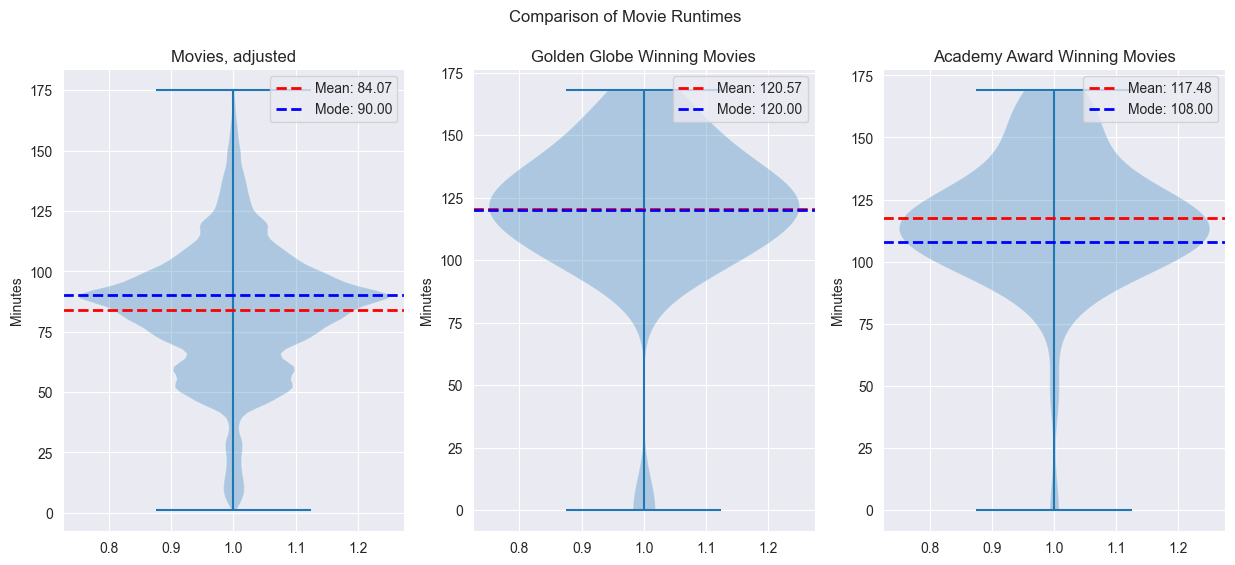

In [73]:
#Calculate mean and mode values for each dataset
mean_runtime2 = Golden_Globes_Winners['runtime_minutes'].mean()
mode_runtime2 = Golden_Globes_Winners['runtime_minutes'].mode().iloc[0]

#Creating thresholds to evaluate our movies, and setting up a lower threshold allow us to discard movies with runtime = 0, which is a placeholder value.
upper_threshold = 175
lower_threshold = 0
runtime_with_threshold = [x for x in imdb['runtime_minutes'] if lower_threshold < x <= upper_threshold]
mean_runtime_adjusted = pd.Series(runtime_with_threshold).mean()  # Convert the list to a Pandas Series

mean_runtime3 = Academy_Awards_Winners['runtime_minutes'].mean()
mode_runtime3 = Academy_Awards_Winners['runtime_minutes'].mode().iloc[0]

#Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 6))

#Plot violin plots and add horizontal lines for mean and mode
def add_mean_mode_lines(ax, data, title):
    ax.violinplot(data)
    ax.set_title(title)
    ax.set_ylabel('Minutes')
    mean_value = data.mean()
    mode_value = data.mode().iloc[0]
    ax.axhline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
    ax.axhline(mode_value, color='blue', linestyle='dashed', linewidth=2, label=f'Mode: {mode_value:.2f}')
    ax.legend()

add_mean_mode_lines(ax2, Golden_Globes_Winners['runtime_minutes'], 'Golden Globe Winning Movies')
add_mean_mode_lines(ax1, pd.Series(runtime_with_threshold), 'Movies, adjusted')
add_mean_mode_lines(ax3, Academy_Awards_Winners['runtime_minutes'], 'Academy Award Winning Movies')

fig.suptitle('Comparison of Movie Runtimes')
plt.show()

There's a clear difference between the length of the overall movies and the award-winning ones.
We can see that they're usually longer than the average runtime of the movies.

We found that the distribution of movie runtimes was different between our overall movie dataset and our set of award-winning movies. After filtering out the movies with listed 0-minute runtimes, as well as any movies longer than 175 minutes, we found:

The mean runtime for all movies is 84.07 minutes

The mean runtime for Academy Award-winning movies  is 120.57 minutes

The mean runtime for Golden Globe-winning movies is 117.48 minutes

### Genres by Award-winning movies

We looked above the amount of movies that fall into each category (we can't forget that a movie can be in more than one category).
Now, we want to see the % of award-winning movies that are part of each individual category, compared to the total movies of the IMDbs dataset. We want to evaluate only the top genres, so we'll keep only the top 10 for visualization purposes.

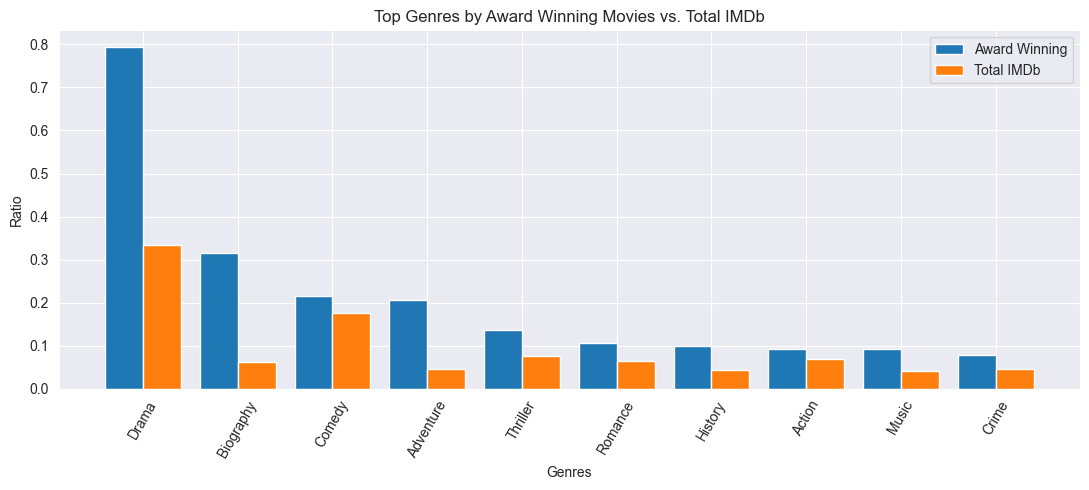

In [74]:
# Creating a list of all the genre-columns
category_columns = ['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
                    'Drama', 'Family', 'Fantasy', 'Game-Show', 'History', 'Horror', 'Music', 'Musical', 'Mystery',
                    'News', 'No Genre', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller',
                    'War', 'Western']

# Calculating the total count of movies per each category in both Academy Awards and Golden Globes
aa_sums = Academy_Awards_Winners[category_columns].sum()
gg_sums = Golden_Globes_Winners[category_columns].sum()

# Getting the total counts of each genre in both datasets
award_winning_sums = aa_sums + gg_sums

# Getting the length of both datasets
size_award_winners = len(Academy_Awards_Winners) + len(Golden_Globes_Winners)

# Calculate the ratio of award-winning movies to the total
award_winning_ratio = award_winning_sums / size_award_winners

# Calculate the ratio of genres in the entire IMDb database
total_genre_counts = imdb[category_columns].sum()
total_ratio = total_genre_counts / len(imdb)

# Sort the genres by their award-winning ratios
sorted_genre_data = pd.DataFrame({'Genre': award_winning_ratio.index, 'Award_Winning_Ratio': award_winning_ratio,
                                  'Total_Ratio': total_ratio})
sorted_genre_data = sorted_genre_data.sort_values(by='Award_Winning_Ratio', ascending=False)

# Number of top genres to keep
top_n_genres = 10

# Select the top N genres by award-winning ratio
top_genres = sorted_genre_data.head(top_n_genres)

# Create a legend for the plot
legend_labels = ['Award Winning', 'Total IMDb']

fig, ax = plt.subplots(figsize=(11, 5))

# Plotting bars for Award Winning and Total IMDb for the top genres
bar_width = 0.4  # Adjust the width of the bars as needed
bar1 = plt.bar(range(len(top_genres)), top_genres['Award_Winning_Ratio'], width=bar_width,
               label=legend_labels[0])
bar2 = plt.bar([x + bar_width for x in range(len(top_genres))],
               top_genres['Total_Ratio'], width=bar_width, label=legend_labels[1])

# Customize the x-axis labels
plt.xticks([i + bar_width / 2 for i in range(len(top_genres))], top_genres['Genre'], rotation=60)

plt.title('Top Genres by Award Winning Movies vs. Total IMDb')
plt.xlabel('Genres')
plt.ylabel('Ratio')

# Add a legend
plt.legend()

plt.tight_layout()
plt.show()

This shows that around 79% of Awards Winning movies have some degree of drama, which is a clear indicator that in order to be more likely to have an award-winning movie, you need to lean into drama.

### Budget of award winning movies vs regular movies

We want to know if there's a difference between the median of the movies that are award winners and the median of the movies in general.

To do this we compared the median of the Golden Globe Winners with the median of the Academy Award winners, then we trace a horizontal line showing the median of all the movies.

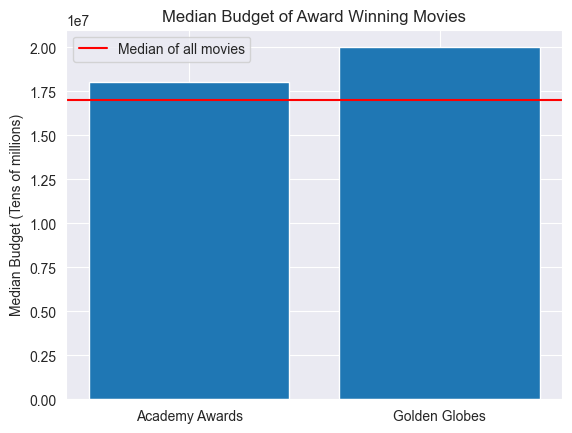

In [75]:
y = [academy_movie_budgets['production_budget'].median(), golden_globes_movie_budgets['production_budget'].median()]
x = ['Academy Awards','Golden Globes']
plt.bar(x=x,height=y)
plt.axhline(y=movie_budgets['production_budget'].median(),color='red',label='Median of all movies')
plt.legend()
plt.ylabel('Median Budget (Tens of millions)')
plt.title('Median Budget of Award Winning Movies');

As we can see here, there's not much difference between them. This means that the budget of a movie is not a determinant factor to whether they'll win awards or not.

### Domestic Gross to Budget

On the other hand, we want to evaluate how much money movies award movies earn in relation to their budget.

To do that we created a Domestic Gross to budget ratio for regular movies, Academy Award winners, and Golden Globe winners. Setting up a threshold of 7 times to allow a clear visualization.

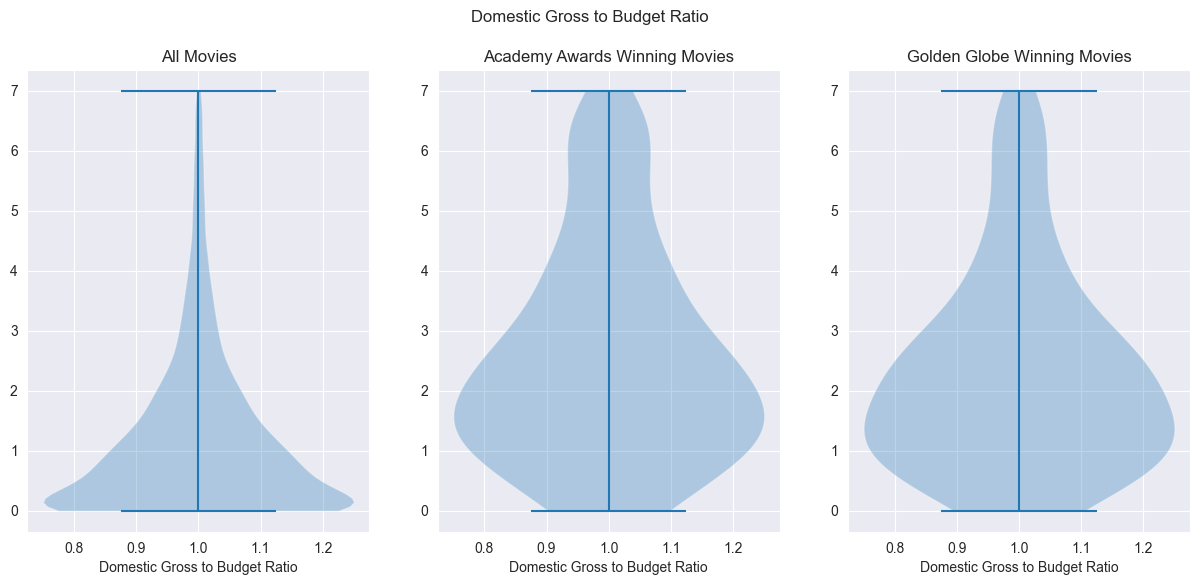

In [76]:
# Setting up the threshold and the values
threshold = 7
domestic_budgets_with_threshold = [x for x in movie_budgets['domestic_gross/production_budget'] if x <= threshold]
gg_with_threshold = [x for x in golden_globes_movie_budgets['domestic_gross/production_budget'] if x <= threshold]
aa_with_threshold = [x for x in academy_movie_budgets['domestic_gross/production_budget'] if x <= threshold]
#Plotting our data
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(15,6))
ax1.violinplot(domestic_budgets_with_threshold)
ax2.violinplot(aa_with_threshold)
ax3.violinplot(gg_with_threshold)
fig.suptitle('Domestic Gross to Budget Ratio')
ax1.set_title('All Movies')
ax2.set_title('Academy Awards Winning Movies')
ax3.set_title('Golden Globe Winning Movies')
ax1.set_xlabel('Domestic Gross to Budget Ratio')
ax2.set_xlabel('Domestic Gross to Budget Ratio')
ax3.set_xlabel('Domestic Gross to Budget Ratio');

There's a difference between the Domestic Gross to budget ratio of award winning movies in relation to regular movies.

We can see in this Violin plot that if we achieve the goal of winning awards, the movie will be also financially sustainable.

It seems that most movies that wins awards are above the 1 ratio, which means they break even, with most of them around 1.5.

On the other side, regular movies seems to perform not as good, with the majority of them in our database performing under 0.5 in this rate, meaning that they don't gross even half of their cost.

## Finding the right Crew

### Directors

Now, we're focusing on finding the adequate people for key positions in the film making process.
Our objective is to find a database that has the best directors based on awards and movies directed.

In [77]:
#Creating a Genre Column List associated with the IMDb table
genre_columns = ['Action', 'Adult',
       'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Game-Show', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'News', 'No Genre', 'Reality-TV', 'Romance',
       'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']

#Grouping all our director's name on the IMDb database, creating a count of the movies they directed.
#We're also keeping the genres columns to evaluate how many of their movies are of the categories we're looking for.
directors = imdb.groupby('director_name').agg({'primary_title':'count', **{col: 'sum' for col in genre_columns}})

# Merging that with both the Academy Awards and the Golden Globe dataset, we don't use the name_matcher function.
# Since we're trying to find the director's name, we need perfect matches.
aa_directors = pd.merge(academy_by_nominee, directors, left_on = 'Name', right_on = 'director_name', how='inner')
gg_directors = pd.merge(golden_globe_by_nominee, directors, left_on = 'Nominee', right_on = 'director_name', how='inner')

#We keep only the most important genres we'd analyze, rename the column to specify why is there, sort by number of awards and Drama, and keep the top 15.
#We do that for both Academy Award Directors and Golden Globe Directors
aa_directors = aa_directors[['Name', 'Number Of Awards', 'primary_title','Adventure','Biography','Drama','Comedy']]
aa_directors.rename(columns={'primary_title':'Number of Movies Directed'}, inplace=True)
aa_directors.sort_values(by=['Number Of Awards','Drama'],ascending=False, inplace=True)
aa_directors = aa_directors.head(15)
gg_directors = gg_directors[['Nominee', 'Number Of Awards', 'primary_title','Adventure','Biography','Drama','Comedy']]
gg_directors.rename(columns={'primary_title':'Number of Movies Directed','Nominee':'Name'}, inplace=True)
gg_directors.sort_values(by=['Number Of Awards','Drama'],ascending=False, inplace=True)
gg_directors = gg_directors.head(15)

#Concatenate both dataframes
best_directors = pd.concat([aa_directors,gg_directors], axis=0)
best_directors.reset_index(drop=True)

#Grouping them by the name, adding up the amount of awards received. Sorting them.
best_directors = best_directors.groupby('Name').agg({'Number Of Awards':'sum', 'Number of Movies Directed':'first','Adventure':'first','Biography':'first','Drama':'first','Comedy':'first'})
best_directors.sort_values(['Number Of Awards','Drama'], ascending=False, inplace=True)

In [78]:
#Create a manual dictionary with all the people in the best_directors dataframe and associating them with their main role.
#We had other people that won awards in other categories and then directed, so we want to make sure that theyre're in the right category.
dt_rol = {'John Williams': 'Soundtrack','Clint Eastwood': 'Director','Oliver Stone': 'Director','Dustin Hoffman': 'Actor','Steven Spielberg': 'Director', 'Robert Redford': 'Director','Francis Ford Coppola': 'Director','Ang Lee': 'Director','Tom Hanks': 'Actor','Martin Scorsese': 'Director','George Clooney': 'Actor','Quentin Tarantino': 'Director', 'Warren Beatty': 'Director', 'Anthony Powell': 'Dead','George Stevens': 'Director','Nick Park': 'Director', 'Woody Allen': 'Director','Damien Chazelle': 'Director', 'Alejandro G. Iñárritu': 'Director','Jodie Foster': 'Actress','Christoph Waltz': 'Actor','Denzel Washington': 'Actor','James L. Brooks':'Director'}

#Add that dictionary into our dataframe as 'Role'
best_directors['Role'] = best_directors.index.map(dt_rol)

In [79]:
best_directors.head()

,Number Of Awards,Number of Movies Directed,Adventure,Biography,Drama,Comedy,Role
Name,,,,,,,
John Williams,8,7,0,0,2,3,Soundtrack
Clint Eastwood,7,6,0,5,6,0,Director
Oliver Stone,7,5,0,1,3,0,Director
Dustin Hoffman,6,1,0,0,1,1,Actor
Steven Spielberg,5,9,4,2,5,0,Director


Our top awarded person is neither a director nor an actor, so is someone worth to add to our team for sure.

In [80]:
#Find just directors
directors = best_directors.loc[best_directors['Role'] == 'Director']
# Sort them by number of award and tie breaking by number of drama movies directed
directors.sort_values(by=['Number Of Awards','Drama'],ascending=False,inplace=True)
#Showing the top three
directors[['Number Of Awards','Number of Movies Directed']].head(3)

,Number Of Awards,Number of Movies Directed
Name,,
Clint Eastwood,7,6
Oliver Stone,7,5
Steven Spielberg,5,9


### Actor and Actress
Now that we found our top three Directors, we'll do the same with actors and actresses.

We'll go back to our Academy Awards and Golden Globe datasets and use the acting awards categories to filter them, and find the most awarded ones

In [81]:
#Filter Just best actor and best actress for our Academy Award Database, grouping by the name of the actor, and creating a count of how many awards they won.
academy_actors = academy_awards.loc[(academy_awards['Award'] == 'Best Actor') | (academy_awards['Award'] == 'Best Actress')]
academy_actors = academy_actors.groupby('Name').agg({'Year': 'first', 'Award': 'count'}).reset_index()
academy_actors.columns = ['Name', 'Year', 'Number Of Awards']
#Sorting by number of awards, keeping the top ten.
academy_actors.sort_values(by=['Number Of Awards'], ascending=False, inplace=True)
top_aa_actors = academy_actors.head(10)

#Applying the same on the Golden globe Database
golden_globe_actors = golden_globe_awards.loc[(golden_globe_awards['category'] == 'Best Actor') | (golden_globe_awards['category'] == 'Best Actress')]
golden_globe_actors = golden_globe_actors.groupby('nominee').agg({'year_film': 'first', 'category': 'count'}).reset_index()
golden_globe_actors.columns = ['nominee', 'Year', 'Number Of Awards']
golden_globe_actors.sort_values(by=['Number Of Awards'], ascending=False, inplace=True)
top_gg_actors = golden_globe_actors.head(10)
#Renaming the column so is the same on both
top_gg_actors.rename(columns={'nominee':'Name'},inplace=True)
#Concatenating both datasets.

top_actors = pd.concat([top_aa_actors,top_gg_actors], axis=0)
top_actors.reset_index(drop=True)
#Grouping by Name, sort by number of awards
top_actors = top_actors.groupby('Name').sum()
top_actors.sort_values(by='Number Of Awards', ascending=False, inplace=True)
top_actors.reset_index(inplace=True)
#Show name and number of awards of our top 5 actors and actresses
top_actors[['Name','Number Of Awards']].head()

,Name,Number Of Awards
0,Meryl Streep,10
1,Jack Nicholson,9
2,Katharine Hepburn,4
3,Dustin Hoffman,4
4,Tom Hanks,4


We can see how this is our top performing actors and actresses as far as awards won.

By doing a manual research, re realized that Katharine Hepburn died in 2003 and Jack Nicholson is retired, so that will discard them from our recommendations.

## Recommendations

* We Recommend that our movie have a certain degree of Drama in it, by the data we saw how relevant the genre is as far as getting award-winning movies.

* A length of around two hours is recommended since the mean of Academy Award winners and Golden Globe winners falls into that category.

* Budget doesn't have to be a primary concern, since it's proven by the data that we don't need to have above-average spending in order to win awards.

* The crew definitely plays an important role in whether a movie can win an award or not. To increase the likelihood of winning an award, we recommend recruiting one of the following directors: Steven Spielberg, Oliver Stone, or Clint Eastwood, the third one is set to retire in 2023, so if we want to include him, we better give him an offer fast. As per actors, the top chosen were: Meryl Streep, Dustin Hoffman, and Tom Hanks.

* John Williams was an outlier on our research, he was so above the rest as far as soundtrack, that he becomes a must when is time to recruit the team for our movie.

# Next Steps

* Update our data to include data of the Academy Awards and the Golden Globes after 2015 and 2020, respectively.

* Create an Analysis of the salary and the budget that our studio will need for the making of a potential award-winning movie.

* Create a prediction model that, given a movie, to determine how likely it is for it to win an award.